In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.pipeline import make_pipeline,FeatureUnion,Pipeline
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from nltk import stem
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
%matplotlib inline

In [5]:
# REMOVING PUNCTUATIONS FROM TRAINING DATA
for i in train_data.index:
    train_data.at[i,'text'] = re.sub(pattern = r'[^\w\s]',repl = "",string = train_data.at[i,'text']).lower()

In [6]:
# Remove some other noise like html tags,symbols,numbers etc.

def remove_noise(text):
    text = re.sub(pattern = '\[.*?\]',repl = '',string = text)
    text = re.sub(pattern = 'https?://\S+|www\.\S+',repl = '',string = text)
    text = re.sub(pattern = '<.*?>+',repl = '',string = text)
    text = re.sub(pattern = '\n',repl = '',string  = text)
    text = re.sub(pattern = '\w*\d\w*',repl= '',string = text)
    return text

In [7]:
for i in train_data.index:
    train_data.at[i,'text'] = remove_noise(train_data.at[i,'text'])

In [8]:
train_data['text']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610                                 s of volcano hawaii 
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [9]:
# REMOVING STOPWORDS FROM TRAINING DATA
for i in train_data.index:
    text = train_data.at[i,'text']
    tokenized_text = word_tokenize(text)
    stopword_removed_text = [word for word in tokenized_text if word not in stopwords.words()]
    train_data.at[i,'text'] = " ".join(stopword_removed_text)

In [10]:
# PUNCTUATION REMOVAL FROM TEST DATA
for i in test_data.index:
    test_data.at[i,'text'] = re.sub(pattern = r'[^\w\s]',repl = "",string = test_data.at[i,'text']).lower()

In [11]:
for i in test_data.index:
    test_data.at[i,'text'] = remove_noise(train_data.at[i,'text'])

In [12]:
# STOPWORDS REMOVAL FROM TEST DATA
for i in test_data.index:
    text = test_data.at[i,'text']
    tokenized_text = word_tokenize(text)
    stopword_removed_text = [word for word in tokenized_text if word not in stopwords.words()]
    test_data.at[i,'text'] = " ".join(stopword_removed_text)

In [13]:
train_size = int(len(train_data) * 0.8)
print ("Train Size: %d" % train_size)
print ("Test Size: %d" % (len(train_data) - train_size))
X_train = train_data['text'][:train_size]
Y_train = train_data['target'][:train_size]
X_val = train_data['text'][train_size:]
Y_val = train_data['target'][train_size:]

Train Size: 6090
Test Size: 1523


## CountVectorization with SVM

In [14]:
svm_C = make_pipeline(CountVectorizer(analyzer = 'word',ngram_range = (1,2)),
                     SGDClassifier(loss = 'hinge',penalty = 'l2',alpha = 0.001,max_iter = 50,random_state = 42)).fit(X_train,Y_train)

In [15]:
# F1-Score for Training & Testing Data
SVM_F1_train_score = f1_score(Y_train,svm_C.predict(X_train),average = 'macro')
SVM_F1_test_score = f1_score(Y_val,svm_C.predict(X_val),average = 'macro')
print('SVM_score_f1(test):{},\nSVM_score_f1(train):{}'.format(SVM_F1_test_score,SVM_F1_train_score))

SVM_score_f1(test):0.7501090798427784,
SVM_score_f1(train):0.9737424140695152


## CountVectorizer with LR

In [16]:
lr1 = make_pipeline(CountVectorizer(analyzer = 'word',ngram_range = (1,2)),
                   LogisticRegression(random_state = 42)).fit(X_train,Y_train)

In [17]:
# F1-Score for Training & Testing Data

lr1_train_score = f1_score(Y_train,lr1.predict(X_train),average = 'macro')
lr1_test_score = f1_score(Y_val,lr1.predict(X_val),average = 'macro')
print('lr1_score_f1(test):{},\nlr1_score_f1(train):{}'.format(lr1_test_score,lr1_train_score))

lr1_score_f1(test):0.7613070180234359,
lr1_score_f1(train):0.9819076474569213


## CountVectorizer + TFIDF with LR

In [18]:
cv = Pipeline([('cv',CountVectorizer(analyzer = 'word',ngram_range = (1,2)))])

In [19]:
feats = FeatureUnion([('cv',cv),('tfidf',TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2)))])

In [20]:
lr2 = make_pipeline(feats,LogisticRegression(random_state = 42)).fit(X_train,Y_train)

In [21]:
lr2_score_train = f1_score(Y_train,lr2.predict(X_train),average = 'macro')
lr2_score_test = f1_score(Y_val,lr2.predict(X_val),average = 'macro')

print('lr2_score_f1(test):{},\nlr2_score_f1(train):{}'.format(lr2_score_test,lr2_score_train))

lr2_score_f1(test):0.7619127254483518,
lr2_score_f1(train):0.9829280419006119


## Stemming

In [22]:
stemmer = stem.SnowballStemmer('english')

def porter_stem(text):
    stemmed_text = [stemmer.stem(word) for word in word_tokenize(text)]
    return " ".join(stemmed_text)

In [23]:
for i in X_train.index:
    text = X_train[i]
    X_train[i] = porter_stem(text)

In [24]:
for i in X_val.index:
    text = X_val[i]
    X_val[i] = porter_stem(text)

## LDA+TFIDF with Logistic regression using Porter stemming

In [25]:
lda = Pipeline([('tf',CountVectorizer(analyzer = 'word',ngram_range = (1,2)))])
lda_tfidf_feats = FeatureUnion([('lda',lda),('tfidf',TfidfVectorizer(strip_accents = 'unicode',min_df = 2,max_df = 0.5))])

In [26]:
stem_lr_model = make_pipeline(lda_tfidf_feats,LogisticRegression(C = 1.5,penalty = 'l2',random_state = 42)).fit(X_train,Y_train)

In [27]:
stem_lr_score_train = f1_score(Y_train,stem_lr_model.predict(X_train),average = 'macro')
stem_lr_score_test = f1_score(Y_val,stem_lr_model.predict(X_val),average = 'macro')

print('Training Score:{},\nTesting Score:{}'.format(stem_lr_score_train,stem_lr_score_test))

Training Score:0.9847934236121038,
Testing Score:0.7586027291834765


## TFIDF with XGboost using Porter Stemming

In [28]:
stem_xgb_model = make_pipeline(TfidfVectorizer(strip_accents = 'unicode',min_df = 2,max_df = 0.5,ngram_range = (1,2)),
                              xgb.XGBClassifier(max_depth = 10,n_estimators = 80,learning_rate = 0.1,colsample_bytree = 0.7,gamma = 0.01,reg_alpha = 4,objective = 'multi:softmax',num_class = 2)).fit(X_train,Y_train)

In [29]:
stem_xgb_train_score = f1_score(Y_train,stem_xgb_model.predict(X_train),average = 'macro')
stem_xgb_test_score = f1_score(Y_val,stem_xgb_model.predict(X_val),average = 'macro')

print('Training Score:{},\nTesting Score:{}'.format(stem_xgb_train_score,stem_xgb_test_score))

Training Score:0.7797261199186254,
Testing Score:0.6824720774385703


## MultinomialNB

In [34]:
multinomial_model = make_pipeline(CountVectorizer(analyzer = 'word',binary = True,ngram_range = (1,2)),
                                 MultinomialNB(alpha = 1)).fit(X_train,Y_train)

In [35]:
multinomial_score_train = f1_score(Y_train,multinomial_model.predict(X_train),average = 'macro')
multinomial_score_test = f1_score(Y_val,multinomial_model.predict(X_val),average = 'macro')

print('Training Score:{},\nTesting Score:{}'.format(multinomial_score_train,multinomial_score_test))

Training Score:0.965885100526058,
Testing Score:0.7798457493381165


Let's Visualize Score 

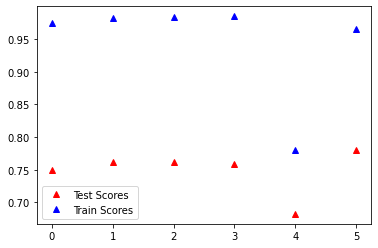

In [36]:
test_scores = [SVM_F1_test_score,lr1_test_score,lr2_score_test,stem_lr_score_test,stem_xgb_test_score,multinomial_score_test]
train_scores = [SVM_F1_train_score,lr1_train_score,lr2_score_train,stem_lr_score_train,stem_xgb_train_score,multinomial_score_train]
labels = ['SVM','lr1','lr2','stem_lr','stem_xgb']
plt.figure()
plt.plot(test_scores,'r^',label = 'Test Scores')
plt.plot(train_scores,'b^',label = 'Train Scores')
#plt.xlabel(labels)
plt.legend()
plt.show()

## Ensemble Model (Majority Voting)

In [37]:
def majority_element(a):
    c = Counter(a)
    value,count = c.most_common()[0]
    
    if count > 1:
        return value
    else:
        return a[1]

In [38]:
svm_prediction = svm_C.predict(X_val)
lr1_predictions = lr1.predict(X_val)
lr2_predictions = lr2.predict(X_val)
stem_lr_prediction = stem_lr_model.predict(X_val)
stem_xgb_prediction = stem_xgb_model.predict(X_val)
multinomial_prediction = multinomial_model.predict(X_val)

In [58]:
merged_predictions = [[pred[0],pred[1],pred[2]] for pred in zip(multinomial_prediction,stem_xgb_prediction,stem_lr_prediction)]

In [59]:
majority_prediction = [majority_element(pred) for pred in merged_predictions]

In [60]:
ensemble_test_score = f1_score(Y_val,majority_prediction,average = 'macro')

print('Test Score:{}'.format(ensemble_test_score))

Test Score:0.7811884445220241


In [61]:
new_X_train = train_data['text'].values
new_Y_train = train_data['target'].values

In [64]:
new_X_train

array(['deed reason earthquak may allah forgiv us',
       'forest fire near rong sask canada',
       'resid ask shelter place notifi offic evacu shelter place order expect',
       ..., 'volcano hawaii',
       'polic investig ebik collid car littl portug ebik rider suffer serious nonlif threaten injuri',
       'latest home raze northern california wildfir abc news'],
      dtype=object)

In [65]:
for i in range(len(new_X_train)):
    text = new_X_train[i]
    new_X_train[i] = porter_stem(text)

In [70]:
X_test = test_data['text'].values

In [71]:
for i in range(len(X_test)):
    text = X_test[i]
    X_test[i] = porter_stem(text)

In [66]:
multinomial_model2 = make_pipeline(CountVectorizer(analyzer = 'word',binary = True,ngram_range = (1,2)),
                                 MultinomialNB(alpha = 1)).fit(new_X_train,new_Y_train)

In [67]:
stem_xgb_model2 = make_pipeline(TfidfVectorizer(strip_accents = 'unicode',min_df = 2,max_df = 0.5,ngram_range = (1,2)),
                              xgb.XGBClassifier(max_depth = 10,n_estimators = 80,learning_rate = 0.1,colsample_bytree = 0.7,gamma = 0.01,reg_alpha = 4,objective = 'multi:softmax',num_class = 2)).fit(new_X_train,new_Y_train)

In [68]:
lda = Pipeline([('tf',CountVectorizer(analyzer = 'word',ngram_range = (1,2)))])
lda_tfidf_feats = FeatureUnion([('lda',lda),('tfidf',TfidfVectorizer(strip_accents = 'unicode',min_df = 2,max_df = 0.5))])

In [69]:
stem_lr_model2 = make_pipeline(lda_tfidf_feats,LogisticRegression(C = 1.5,penalty = 'l2',random_state = 42)).fit(new_X_train,new_Y_train)

In [72]:
stem_lr_prediction2 = stem_lr_model2.predict(X_test)
stem_xgb_prediction2 = stem_xgb_model2.predict(X_test)
multinomial_prediction2 = multinomial_model2.predict(X_test)

In [74]:
merged_predictions2 = [[pred[0],pred[1],pred[2]] for pred in zip(multinomial_prediction2,stem_xgb_prediction2,stem_lr_prediction2)]

In [75]:
majority_prediction2 = [majority_element(pred) for pred in merged_predictions2]

In [76]:
ids = test_data['id']

In [78]:
target = pd.DataFrame(majority_prediction2,columns = ['target'])

In [79]:
submission = pd.concat([ids,target],axis = 1)

In [80]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [81]:
submission.to_csv('Real_or_Fake_submission3.csv',index = False)

In [82]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub

In [83]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
hub_layer = hub.KerasLayer(embedding,input_shape = [],dtype = tf.string,trainable = True)

In [84]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(units = 20,activation = 'relu'))
model.add(tf.keras.layers.Dense(1,activation = 'relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 389,821
Trainable params: 389,821
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
             metrics = ['accuracy'])

In [86]:
EPOCHS = 50

In [87]:
hist = model.fit(new_X_train,new_Y_train,epochs = EPOCHS,validation_split=0.2,verbose = 2)

Epoch 1/50
191/191 - 1s - loss: 0.6905 - accuracy: 0.6197 - val_loss: 0.6605 - val_accuracy: 0.6487
Epoch 2/50
191/191 - 1s - loss: 0.6541 - accuracy: 0.7008 - val_loss: 0.6495 - val_accuracy: 0.6848
Epoch 3/50
191/191 - 1s - loss: 0.6334 - accuracy: 0.7383 - val_loss: 0.6425 - val_accuracy: 0.6934
Epoch 4/50
191/191 - 1s - loss: 0.6144 - accuracy: 0.7658 - val_loss: 0.6286 - val_accuracy: 0.7177
Epoch 5/50
191/191 - 1s - loss: 0.5967 - accuracy: 0.7900 - val_loss: 0.6222 - val_accuracy: 0.7406
Epoch 6/50
191/191 - 1s - loss: 0.5814 - accuracy: 0.8061 - val_loss: 0.6142 - val_accuracy: 0.7603
Epoch 7/50
191/191 - 1s - loss: 0.5683 - accuracy: 0.8240 - val_loss: 0.6174 - val_accuracy: 0.7551
Epoch 8/50
191/191 - 1s - loss: 0.5573 - accuracy: 0.8363 - val_loss: 0.6285 - val_accuracy: 0.7525
Epoch 9/50
191/191 - 1s - loss: 0.5482 - accuracy: 0.8463 - val_loss: 0.6300 - val_accuracy: 0.7479
Epoch 10/50
191/191 - 1s - loss: 0.5413 - accuracy: 0.8540 - val_loss: 0.6353 - val_accuracy: 0.7472

In [88]:
pred = model.predict(X_test)

In [89]:
prediction = []
for p in pred:
    if p>0:
        prediction.append(1)
    else:
        prediction.append(0)

In [90]:
target2 = pd.DataFrame(data = prediction,columns = ['target'])

In [91]:
submission = pd.concat([ids,target2],axis = 1)

In [92]:
submission.to_csv('Real_or_fake_NLP_submission2.csv',index=False)